# Potential Field

In [ ]:
from setproctitle import setproctitle
setproctitle("Potential")

In [ ]:
import os

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

In [ ]:
#| default_exp potential_field

In [ ]:
#| export
import numpy as np
import torch
from astropy.nddata import block_replicate
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

## Whole Field

In [ ]:
#| export
class PotentialModel(nn.Module):
    def __init__(self, b_n, r_p):
        super().__init__()
        self.register_buffer('b_n', b_n)
        self.register_buffer('r_p', r_p)
        c = np.zeros((1, 3))
        c[:, 2] = (1 / np.sqrt(2 * np.pi))
        c = torch.tensor(c, dtype=torch.float32, )
        self.register_buffer('c', c)

    def forward(self, coord):
        v1 = self.b_n[:, None]
        v2 = 2 * np.pi * ((-self.r_p[:, None] + coord[None, :] + self.c[None]) ** 2).sum(-1) ** 0.5
        potential = torch.sum(v1 / v2, dim=0)
        return potential


def get_potential(b_n, height, batch_size=2048, strides=(1, 1, 1), progress=True):
    cube_shape = (*b_n.shape, height)
    strides = (strides, strides, strides) if isinstance(strides, int) else strides
    b_n = b_n.reshape((-1,)).astype(np.float32)
    coords = np.stack(np.mgrid[:cube_shape[0]:strides[0], :cube_shape[1]:strides[1], :cube_shape[2]:strides[2]], -1).reshape((-1, 3))
    r_p = np.stack(np.mgrid[:cube_shape[0], :cube_shape[1], :1], -1).reshape((-1, 3))

    # torch code
    # r = (x * y, 3); coords = (x*y*z, 3), c = (1, 3)
    # --> (x * y, x * y * z, 3) --> (x * y, x * y * z) --> (x * y * z)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    with torch.no_grad():
        b_n = torch.tensor(b_n, dtype=torch.float32, )
        r_p = torch.tensor(r_p, dtype=torch.float32, )
        model = nn.DataParallel(PotentialModel(b_n, r_p)).to(device)

        coords = torch.tensor(coords, dtype=torch.float32)
        potential = []
        loader = DataLoader(TensorDataset(coords), batch_size=batch_size, num_workers=8)
        it = tqdm(loader, desc='Potential Field') if progress else loader
        for coord, in it:
            coord = coord.to(device)
            p_batch = model(coord)
            potential += [p_batch]

    potential = torch.cat(potential).view(cube_shape).cpu().numpy()
    if strides != (1, 1, 1):
        potential = block_replicate(potential, strides, conserve_sum=False)
    return potential

def get_potential_field(b_n, height, *args, **kwargs):
    potential = get_potential(b_n, height, *args, **kwargs)
    b = - 1 * np.stack(np.gradient(potential, axis=[0, 1, 2], edge_order=2), axis=-1)
    return b

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
b_bottom_path = os.path.expanduser('~/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_000000.npy')

In [ ]:
with open(b_bottom_path, 'rb') as f:
    b_bottom = np.load(f)

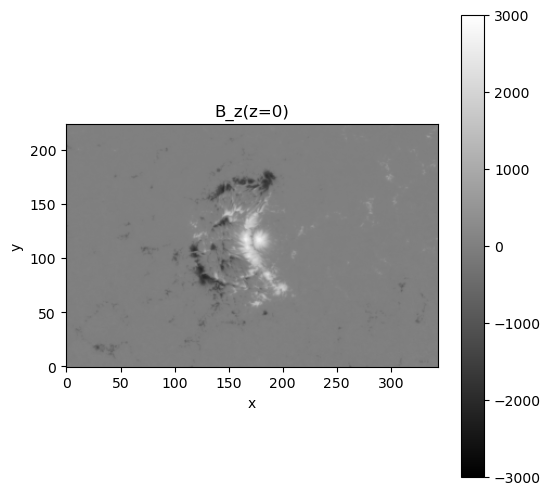

In [ ]:
plt.close()
fig, ax = plt.subplots(figsize=(6,6))
CS = plt.imshow(b_bottom[:, :, 2].transpose(), origin='lower', cmap='gray', vmin=-3000, vmax=3000)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title("B_z(z=0)")
fig.colorbar(CS)
plt.show()

In [ ]:
bz_bottom = b_bottom[:, :, 2]
bz_bottom.shape

(344, 224)

In [ ]:
Nz = 160

In [ ]:
#| export
from cmspinn.mag_viz import create_coordinates
import pyvista as pv

In [ ]:
#| export
class potential_cube:
    def __init__(self, bz_bottom, Nz):
        self.bz_bottom = bz_bottom
        self.Nz = Nz

        self.Nx, self.Ny = bz_bottom.shape

    def cal_and_save_potential_field(self, vtk_path, batch_size=10000):
        bz_bottom = self.bz_bottom
        Nx, Ny, Nz = self.Nx, self.Ny, self.Nz

        B_pot = get_potential_field(bz_bottom, Nz, batch_size=10000)
        
        Bx = B_pot[..., 0]
        By = B_pot[..., 1]
        Bz = B_pot[..., 2]

        co_bounds = (0, Nx-1, 0, Ny-1, 0, Nz-1)
        co_coords = create_coordinates(co_bounds).reshape(-1, 3)
        co_coord = co_coords.reshape(Nx, Ny, Nz, 3)
        x = co_coord[..., 0]
        y = co_coord[..., 1]
        z = co_coord[..., 2]
        mesh = pv.StructuredGrid(x, y, z)
        vectors = np.stack([Bx, By, Bz], axis=-1).transpose(2, 1, 0, 3).reshape(-1, 3)
        mesh['B'] = vectors
        mesh.active_vectors_name = 'B'
        magnitude = np.linalg.norm(vectors, axis=-1)
        mesh['mag'] = magnitude
        mesh.active_scalars_name = 'mag'

        self.grid = mesh 
        self.grid.save(vtk_path)
        return self.grid

In [ ]:
potential_maker = potential_cube(bz_bottom, Nz)

In [ ]:
b_bottom_date = os.path.basename(b_bottom_path)[9:-4]

In [ ]:
from pathlib import Path

In [ ]:
pot_path = os.path.join(Path(b_bottom_path).parent.parent, 'b_potential')
os.makedirs(pot_path, exist_ok=True)

In [ ]:
vtk_path = os.path.join(pot_path, f'b_potential_{b_bottom_date}.vtk')

In [ ]:
potential_maker.cal_and_save_potential_field(vtk_path)

Potential Field: 100%|██████████| 6020/6020 [02:37<00:00, 38.33it/s]


StructuredGrid (0x7f38d7973400)
  N Cells:      12161751
  N Points:     12328960
  X Bounds:     0.000e+00, 3.430e+02
  Y Bounds:     0.000e+00, 2.230e+02
  Z Bounds:     0.000e+00, 1.590e+02
  Dimensions:   344, 224, 160
  N Arrays:     2

In [ ]:
B_pot_mesh = pv.read(vtk_path)

In [ ]:
from cmspinn.mag_viz import mag_plotter

In [ ]:
pv.start_xvfb()
pv.global_theme.trame.server_proxy_enabled = True
pv.set_jupyter_backend('static')

In [ ]:
B_pot = mag_plotter(B_pot_mesh)

In [ ]:
vmin = -3000
vmax = 3000

i_siz = 160
j_siz = 100

i_res = 15
j_res = 15

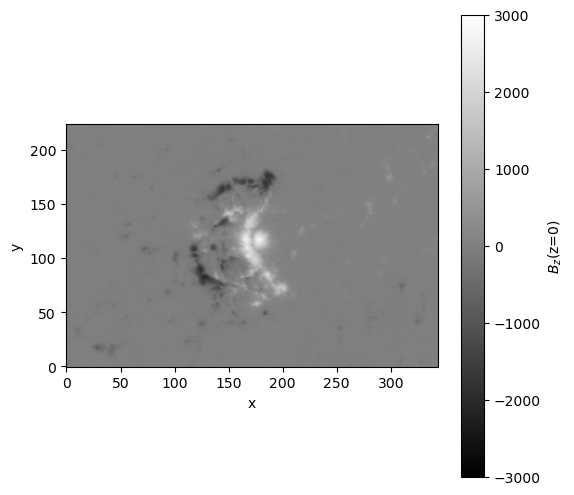

In [ ]:
B_pot.plt_Bz_imshow(z=0, vmin=vmin, vmax=vmax)

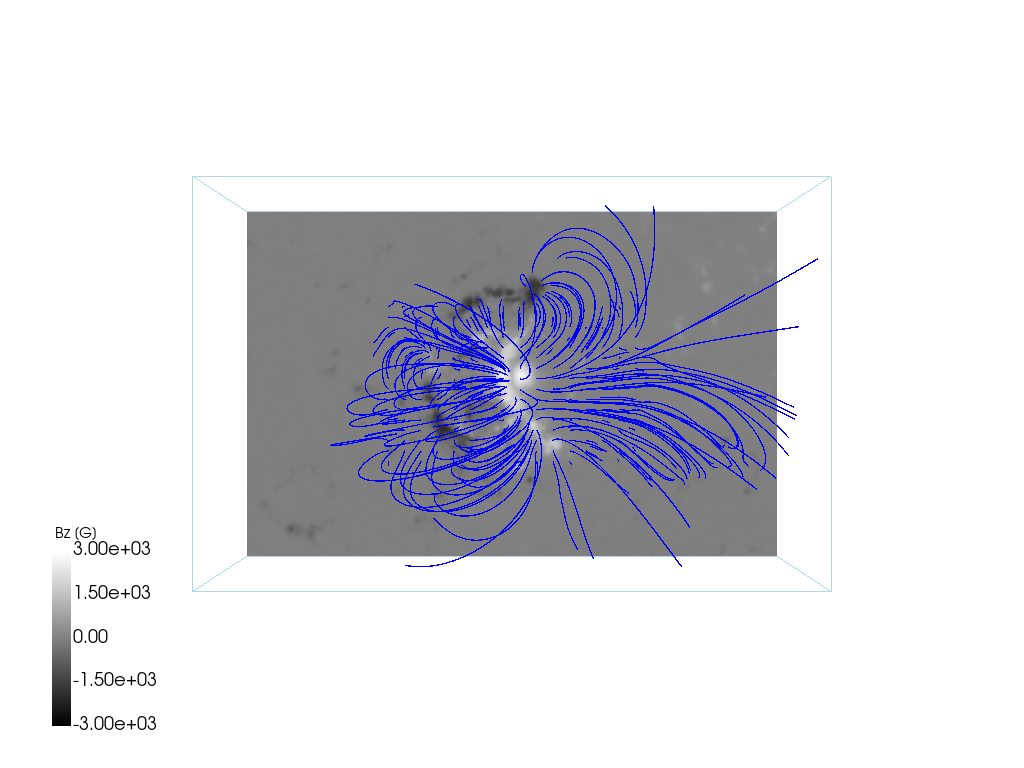

<pyvista.plotting.plotter.Plotter>

In [ ]:
B_pot.pv_streamline_Bz(camera_position='xy', i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax)

## Boundary

In [ ]:
#| export
def get_potential_boundary(b_n, height, batch_size=2048, **kwargs):
    assert not np.any(np.isnan(b_n)), 'Invalid data value'

    cube_shape = (*b_n.shape, height)

    b_n = b_n.reshape((-1)).astype(np.float32)
    coords = [np.stack(np.mgrid[:cube_shape[0], :cube_shape[1], cube_shape[2] - 2:cube_shape[2] + 1], -1),       #top
              np.stack(np.mgrid[:cube_shape[0], -1:2, :cube_shape[2]], -1),                                      #y=0
              np.stack(np.mgrid[:cube_shape[0], cube_shape[1] - 2:cube_shape[1] + 1, :cube_shape[2]], -1),       #y=max
              np.stack(np.mgrid[-1:2, :cube_shape[1], :cube_shape[2]], -1),                                      #x=0
              np.stack(np.mgrid[cube_shape[0] - 2:cube_shape[0] + 1, :cube_shape[1], :cube_shape[2]], -1), ]     #x=max
    fields = _compute_fields(coords, cube_shape, b_n, batch_size=batch_size, **kwargs)

    fields = [fields[0][:, :, 1],
              fields[1][:, 1, :], fields[2][:, 1, :],
              fields[3][1, :, :], fields[4][1, :, :]]
    coords = [coords[0][:, :, 1],
              coords[1][:, 1, :], coords[2][:, 1, :],
              coords[3][1, :, :], coords[4][1, :, :]]
    return coords, fields

def _compute_fields(coords, cube_shape, b_n, batch_size=2048, progress=False):
    coords_shape = [c.shape[:-1] for c in coords]
    flat_coords = np.concatenate([c.reshape(((-1, 3))) for c in coords])

    r_p = np.stack(np.mgrid[:cube_shape[0], :cube_shape[1], :1], -1).reshape((-1, 3))

    # torch code
    # r = (x * y, 3); coords = (x*y*z, 3), c = (1, 3)
    # --> (x * y, x * y * z, 3) --> (x * y, x * y * z) --> (x * y * z)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    with torch.no_grad():
        b_n = torch.tensor(b_n, dtype=torch.float32, )
        r_p = torch.tensor(r_p, dtype=torch.float32, )
        model = nn.DataParallel(PotentialModel(b_n, r_p, )).to(device)

        flat_coords = torch.tensor(flat_coords, dtype=torch.float32, )

        potential = []
        iter = DataLoader(TensorDataset(flat_coords), batch_size=batch_size, num_workers=2)
        iter = iter if progress else tqdm(iter, desc='Potential Field')
        for coord, in iter:
            coord = coord.to(device)
            p_batch = model(coord)
            potential += [p_batch.cpu()]

    potential = torch.cat(potential).numpy()
    idx = 0
    fields = []
    for s in coords_shape:
        p = potential[idx:idx + np.prod(s)].reshape(s)
        b = - 1 * np.stack(np.gradient(p, axis=[0, 1, 2], edge_order=2), axis=-1)
        fields += [b]
        idx += np.prod(s)

    return fields

In [ ]:
#| export
import pickle

In [ ]:
#| export
def cal_and_save_potential_boundary_for_spinn(b_bottom, Nz, b_norm, boundary_path):
    bz_bottom = b_bottom[:, :, 2]

    coords, fields = get_potential_boundary(b_bottom[:, :, 2], Nz)

    #0 z=0   bottom
    #1 z=2   top                  
    #2 x=0   lateral_1            
    #3 x=2   lateral_2            
    #4 y=0   lateral_3            
    #5 y=2   lateral_4    

    bp_top = fields[0]
    bp_lateral_3 = fields[1]
    bp_lateral_4 = fields[2]
    bp_lateral_1 = fields[3]
    bp_lateral_2 = fields[4]

    b_bottom_norm = b_bottom / b_norm
    bp_top_norm = bp_top / b_norm
    bp_lateral_1_norm = bp_lateral_1 / b_norm
    bp_lateral_2_norm = bp_lateral_2 / b_norm
    bp_lateral_3_norm = bp_lateral_3 / b_norm 
    bp_lateral_4_norm = bp_lateral_4 / b_norm

    boundary_data = (b_bottom_norm, bp_top_norm, bp_lateral_1_norm, bp_lateral_2_norm, bp_lateral_3_norm, bp_lateral_4_norm)

    with open(boundary_path, "wb") as f:
        pickle.dump(boundary_data, f)